# MCFOST Python Library Demo

**Assumptions:** This demo assumes you are familiar with the basics of the MCFOST astrophysical radiative transfer code, and have a working copy of that installed on your system. 

This demo further assumes you are running this notebook from its location within a copy of mcfost-python git directory; specifically that there's a subdirectory named 'docs/example' which contains the ref2.19.para sample parameter file, and optionally the results of running MCFOST on it to produce an SED and an image at 1.0 microns. You can do that directly from the command line as follows, or we will show below how to invoke this from within Python. 

   >  mcfost ref2.20.para -rt

   >  mcfost ref2.20.para -img 1.0 -rt

In [1]:
%load_ext autoreload
%autoreload 2
%aimport mcfost
%matplotlib inline

import numpy as np

Quick test of the extinction calculator:

In [2]:
print(mcfost.ccm_extinction(3.1,[0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]))

[ 2.94121201  2.88260425  1.37797835  0.79933598  0.4339158   0.25539264
  0.16192279  0.06803995  0.01810171  0.01516129  0.01300451  0.01130458]


## General Overview

This package implements a set of Python object classes to represent the different sorts of datasets one encounters when working with MCFOST: parameter files, model results including SEDs and images, observation results including SEDs and images. The intent is that the model SED class and the observed SED class interfaces look as similar as possible, and likewise for the images. 

Once you have both model and observed data, it becomes possible to calculate chi^2 for individual fits, and use these to generate the relative conditional probability of a model given the data. This can be used in an MCMC calculation using the emcee package to derive the overall posterior probability distributions. 

## Working with Parameter Files

We can read in parameter files into a ``Paramfile`` object:

In [3]:
par = mcfost.Paramfile('docs/example/ref2.20.para')

The resulting object's attributes provide read/write access to all the settings in that parameter file. There are many, many of these. 

In [4]:
print("Distance:", par.distance, 'pc')
print("Wavelength range:", par.lambda_min, " to", par.lambda_max, "microns")

print("Changing distance to 200 pc")
par.distance = 200
print("Distance:", par.distance, 'pc')

Distance: 140.0 pc
Wavelength range: 0.1  to 3000.0 microns
Changing distance to 200 pc
Distance: 200 pc


This also includes some quantities which are computed from the parameters, not directly stated in the parameter file.  Currently these computed quantities are only calculated when the Paramfile is read from disk, and don't automatically update if you change some setting. This should be improved eventually. 

In [5]:
print("Wavelengths", par.wavelengths)
print("Inclinations in RT mode: ", par.inclinations)

Wavelengths [  1.10859065e-01   1.36242824e-01   1.67438785e-01   2.05777785e-01
   2.52895390e-01   3.10801666e-01   3.81966929e-01   4.69427133e-01
   5.76913383e-01   7.09011107e-01   8.71355674e-01   1.07087280e+00
   1.31607401e+00   1.61741974e+00   1.98776557e+00   2.44291068e+00
   3.00227185e+00   3.68971175e+00   4.53455699e+00   5.57284917e+00
   6.84888248e+00   8.41709327e+00   1.03443824e+01   1.27129691e+01
   1.56238987e+01   1.92013534e+01   2.35979494e+01   2.90012482e+01
   3.56417578e+01   4.38027665e+01   5.38324276e+01   6.61586128e+01
   8.13071645e+01   9.99243290e+01   1.22804326e+02   1.50923230e+02
   1.85480610e+02   2.27950706e+02   2.80145316e+02   3.44291096e+02
   4.23124542e+02   5.20008738e+02   6.39076821e+02   7.85408309e+02
   9.65245791e+02   1.18626124e+03   1.45788332e+03   1.79169958e+03
   2.20195083e+03   2.70613864e+03]
Inclinations in RT mode:  [ 45.]


Some of the items which can be repeated multiple times in a parameter files are stored as lists of dicts.  For instance, there's a "density_zones" list attribute (which can have multiple entries if there are multiple zones defined), each of which in turn contains a "dust" list attribute (which can have multiple entries if that zone has more than one type of dust.)

In [6]:
print(par.density_zones)

[{'dust_mass': 0.001, 'edge': 0.0, 'r_critical': 100.0, 'flaring_exp': 1.125, 'reference_radius': 100.0, 'r_out': 300.0, 'gamma_exp': 0.0, 'zone_type': 1, 'debris_disk_vertical_profile_exponent': 2.0, 'gas_to_dust_ratio': 100.0, 'grain_type': 'Mie', 'dust_nspecies': 1, 'scale_height': 10.0, 'dust': [{'mixing_rule': 2, 'amin': 0.03, 'porosity': 0.0, 'grain_type': 'Mie', 'mass_fraction': 1.0, 'ncomponents': 1, 'filename': 'Draine_Si_sUV.dat', 'volume_fraction': 1.0, 'aexp': 3.5, 'amax': 2000.0, 'ngrains': 100, 'heating': 1}], 'r_in': 1.0, 'surface_density_exp': -0.5}]


This can all get rather complicated. There are some convenience shorthands defined for accessing the first elements of these lists, for instance ``par.dust`` is equivalent to ``par.density_zones[0]['dust'][0]``. If you want to access more than the first one you must use the full syntax. 

**Cautionary Note:** The API for this all could use some cleanup; the names used for the various different parameter settings are not entirely consistent. We should think some about how much we can try for consistent naming conventions between the Python, IDL, Yorick variable names and the name/descriptions used in the software manual.  And furthermore the Python code here is not yet consistent in terms of using objects with attributes versus dicts. This needs to be made better, time permitting. 

You can view a parameter file in text form just by casting it to a string, and there is a ".writeto()" method to save it to a file.

In [7]:
print(par)

2.20                      mcfost version

#Number of photon packages
  1.28e+05                nbr_photons_eq_th  : T computation
  1280                    nbr_photons_lambda : SED computation
  1.28e+05                nbr_photons_image : images computation

#Wavelength
  50  0.1   3000          n_lambda, lambda_min, lambda_max [microns]
  T T T                   compute temperature?, compute sed?, use default wavelength grid ?
  IMLup.lambda           wavelength file (if previous parameter is F)
  F T                     separation of different contributions?, stokes parameters?

#Grid geometry and size
  1                       1 = cylindrical, 2 = spherical, 3 = Voronoi tesselation (this is in beta, please ask Christophe)
  100  70  1 20           n_rad (log distribution), nz (or n_theta), n_az, n_rad_in

#Maps
  101 101 3000.0        grid (nx,ny), size [AU]
  10 1               MC : N_bin_incl, N_bin_az
  45.0  45.0   1 F    RT: imin, imax, n_incl, centered ?
  0.0   0.0    1    RT

## Running MCFOST calculations

MCFOST calculations may be executed for a given parameter file or for many parameter files at once. 

Note that when you run a parameter file, the wrapper function may optionally move that parameter file to a new subdirectory before running it. This is useful if you're running a grid or MCMC and want each parameter file's results in its own subdirectory (the typical case). But you can disable this behavior if it's not desired. 

For example, the following line will create an SED and two images for the example reference parameter file included with MCFOST and with this Python package. Warning, this will take a long time to run:  

In [8]:
type('docs/example/ref2.20.para')
res = mcfost.run_one_file('docs/example/ref2.20.para', wavelengths=[0.8, 1.0], move_to_subdir=False)

INFO:mcfost:Running MCFOST for: docs/example/ref2.20.para
INFO:mcfost:Computing SED for docs/example/ref2.20.para
INFO:mcfost:SED results written to /Users/cpinte/mcfost-python/docs/example/data_th
INFO:mcfost:Computing image at 0.8 microns for docs/example/ref2.20.para
INFO:mcfost:Computing image at 1.0 microns for docs/example/ref2.20.para
INFO:mcfost:Calculation complete.


# Working with Model Results

The ModelResults class provides an interface to work with MCFOST model results for *a single model*. You instantiate it with a directory path to an MCFOST results directory (i.e. the parent directory that contains 'data_th' as a subdirectory.)


In [9]:
model = mcfost.ModelResults('docs/example/')
print(model)
print(list(model._wavelengths_lookup.values()))
model.describe()

<MCFOST ModelResults in directory '/Users/cpinte/mcfost-python/docs/example'>
['0.8', '1.0']
Model results in /Users/cpinte/mcfost-python/docs/example for ref2.20.para
    Model has 1 inclinations from 45.0 to 45.0
    SED computed from 0.1 - 3000.0 microns using 50 wavelengths
    Images computed for 2 wavelengths: [ 0.8  1. ] micron


## Working with Model Results: SEDs

The model contains an ``sed`` attribute which is an object representing the calculated SED, and an ``images`` attribute which is a dict of objects representing all available image wavelengths. 

For the ``sed`` object, there are attributes ``.wavelength``, ``.flux``, ``.nu_fnu``, ``.uncert`` and so forth. The results are returned as ``astropy.Quantity`` arrays with the appropriate units.  ``wavelength`` and ``inclination`` are 1D arrays, while ``flux`` and so forth are 2D arrays with shape equal to (# of inclinations, # of wavelengths).

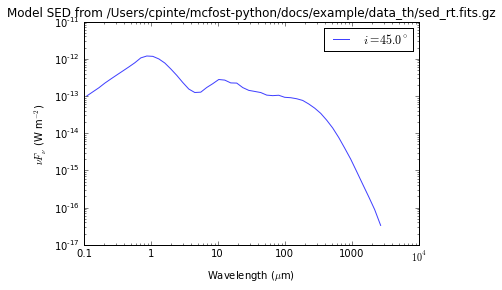

In [10]:
model.sed.plot()

In [11]:
model.sed.wavelength

<Quantity [  1.10859065e-01,  1.36242824e-01,  1.67438785e-01,
             2.05777785e-01,  2.52895390e-01,  3.10801666e-01,
             3.81966929e-01,  4.69427133e-01,  5.76913383e-01,
             7.09011107e-01,  8.71355674e-01,  1.07087280e+00,
             1.31607401e+00,  1.61741974e+00,  1.98776557e+00,
             2.44291068e+00,  3.00227185e+00,  3.68971175e+00,
             4.53455699e+00,  5.57284917e+00,  6.84888248e+00,
             8.41709327e+00,  1.03443824e+01,  1.27129691e+01,
             1.56238987e+01,  1.92013534e+01,  2.35979494e+01,
             2.90012482e+01,  3.56417578e+01,  4.38027665e+01,
             5.38324276e+01,  6.61586128e+01,  8.13071645e+01,
             9.99243290e+01,  1.22804326e+02,  1.50923230e+02,
             1.85480610e+02,  2.27950706e+02,  2.80145316e+02,
             3.44291096e+02,  4.23124542e+02,  5.20008738e+02,
             6.39076821e+02,  7.85408309e+02,  9.65245791e+02,
             1.18626124e+03,  1.45788332e+03,  1.791699

In [12]:
model.sed.flux.shape

(1, 50)

## Working with Model Results: Images

Each ModelResults instance will have an attribute ``.images`` which is a collection containing the different image outputs. This looks like a Python ``dict`` but with some convenience customizations for use with MCFOST. For instance you can index it with either strings or floats for the wavelength interchangably. 

Each item in this dict is an ``astropy.io.fits`` HDU containing the image data and its header. 

In [13]:
model.images.wavelengths

<Quantity [ 0.8, 1. ] micron>

In [14]:
print(model.images.keys())

dict_values(['0.8', '1.0'])


In [15]:
print(model.images[0.8])
print(model.images['0.8'])  # This is the exact same 
print(model.images[' 000.8000'])  # So is this

In [16]:
model.images[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    5 / number of data axes                            
NAXIS1  =                  101 / length of data axis 1                          
NAXIS2  =                  101 / length of data axis 2                          
NAXIS3  =                    1 / length of data axis 3                          
NAXIS4  =                    1 / length of data axis 4                          
NAXIS5  =                    4 / length of data axis 5                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WAVE    =                   1. / wavelength [microns]                           
CTYPE1  = 'RA---TAN'        

For now there is a "plot_image" function to display images. Maybe eventually this should become a method on a ModelImage object once such a thing would exist? 

/Users/cpinte/Software/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


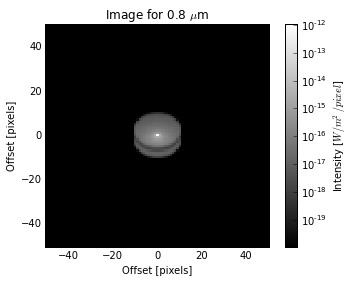

In [17]:
model.plot_image(0.8, axes_units='pixels', dynamic_range=1e8, colorbar=True)

## Working with Observed Data

The observations class is compatible with the same file formats and index file that MCRE uses. You can instantiate it with a path for a directory containing the observations and the index text file. 

In [ ]:
#obs = mcfost.Observations('/Users/mperrin/data/mcfost/esoha569/observations')

There are ``.file_names``, ``.file_types``, and ``.file_wavelengths`` attributes that contain the entries from that table. 

In [ ]:
#print obs.file_names

The observations SED looks essentially identical to the model SED in its class interface. 

In [ ]:
#obs.sed.wavelength

In [ ]:
#obs.sed.plot()

Using these it's simple to plot an observed and model SED together, and then customize the plot however you'd like:

In [ ]:
#ax = model.sed.plot()
#obs.sed.plot(overplot=True)

#ax.set_xlim(0.05, 3e5)
#ax.set_title('Comparison of some model and data')

## Misc Scratch Space Code Below Here

In [18]:
par.star

rec.array((4000.0, 2.0, 1.0, b'lte4000-3.5.NextGen.fits.gz', True, 2.2, 0.0, 0.0, 0.0, 0.1), 
          dtype=[('temp', '<f8'), ('radius', '<f8'), ('mass', '<f8'), ('spectrum', '|S80'), ('l_is_blackbody', '|b1'), ('slope_fUV', '<f8'), ('z', '<f8'), ('y', '<f8'), ('x', '<f8'), ('fUV', '<f8')])

In [25]:
names = par.star.dtype
#values = np.asarray(par.star[0].values())
#dtypes = ['a30' if n=='spectrum' else 'f8' for n in names]
print(names)

#np.array(par.star[0].items(), dtype=dtypes)

(numpy.record, [('temp', '<f8'), ('radius', '<f8'), ('mass', '<f8'), ('spectrum', 'S80'), ('l_is_blackbody', '?'), ('slope_fUV', '<f8'), ('z', '<f8'), ('y', '<f8'), ('x', '<f8'), ('fUV', '<f8')])
